In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = list(left.select_traces())
    t2 = list(right.select_traces())
    _clear_props([*t1, *t2])
    fig.add_traces(t1, rows=1, cols=1)
    fig.add_traces(t2, rows=1, cols=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [3]:
dogs = pd.read_csv('data/akc.csv').dropna()
earn = (pd.read_csv('data/earnings2020.csv')
        .replace([1, 2, 3, 4, 5], ["<HS", "HS", "<BA", "BA", ">BA"]))

sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)

def subset(df):
    return df.loc[(df['price'] < 4_000_000) &
                  (df['bsqft'] < 12_000)]

def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    eight_up = sfh.loc[sfh['br'] >= 8, 'br'].unique()
    new_bed = sfh['br'].replace(eight_up, 8)
    return sfh.assign(br=new_bed)

sfh = (sfh_all
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
)

b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


(ch:viz_comparisons)=
# Facilitating Meaningful Comparisons


The same data can be visualized many different ways, and deciding which plot to make can be daunting. Generally speaking, our plot should help a reader make meaningful comparisons. In this section, we go over several useful principles that can improve the clarity of our plots.

## Emphasize the Important Difference

Whenever we make a plot that compares groups, we should ask: does the plot emphasize the important difference? 
As a rule of thumb, it's easier for readers to see differences when
plotting objects are aligned in ways that make the comparisons easier to read. Let's look at an example.

The US Bureau of Labor Statistics publishes data on income[^BLS].
We've taken the 2020 median full-time-equivalent weekly earnings for people over 25 and plotted them below.
We've split people into groups by education level and sex.

[^BLS]:https://www.bls.gov/opub/reports/womens-earnings/2020/home.htm

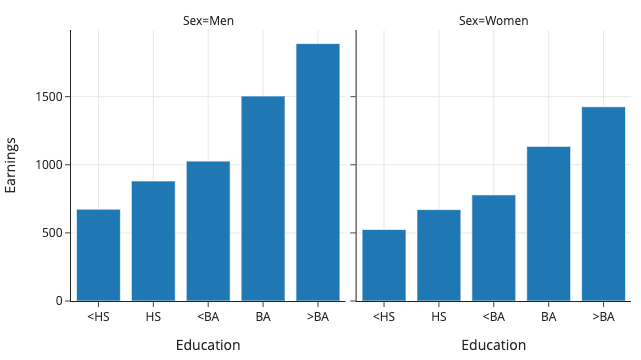

In [4]:
labels = {'educ': 'Education', 'income': 'Earnings', 'gender':'Sex'}
fig = px.bar(earn, x='educ', y='income', facet_col='gender',
             labels=labels,
             width=450, height=250)
margin(fig, t=30)

These bar plots show that earnings increase with more education. 
But arguably, a more interesting comparison is between men and women of the same education level.
We can try grouping the bars differently to focus instead on this comparison.

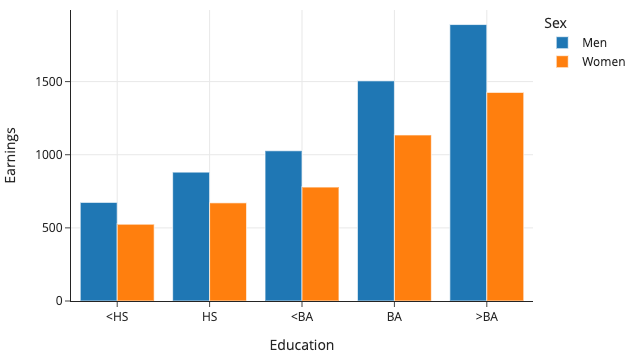

In [7]:
px.bar(earn, x='educ', y='income', color='gender',
             barmode='group',
             labels=labels,
             width=450, height=250)

This plot is much better, we can more easily compare the earnings of men and women for each level of education.
However, we can make this difference even more clear using vertical alignment.
Instead of bars, we use dots that align vertically for each education level.

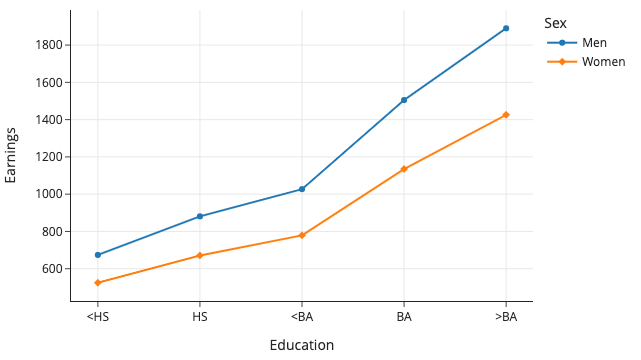

In [13]:
px.line(earn, x='educ', y='income', symbol='gender', color='gender',
        labels=labels, width=450, height=250)

This plot more clearly reveals an important difference:
the earning gap between men and women grows with education.
We considered three plots in this example; they plot the same data, but they differ in how readily we can see the message in the plot. We prefer the last one because it aligns the income differences vertically, making them easier to compare. 

Notice that in making all three plots, we ordered the education categories from the least to greatest number of years of education. This ordering makes sense because education level is ordinal. When we compare nominal categories, we use other approaches to ordering categories. 

## Ordering Groups 

With ordinal features, we keep the categories in their natural order when we make plots, but the same principle does not apply for nominal features. Instead,  we choose an ordering that helps us make comparisons. With bar plots, it's good practice to order the bars according to their height. While for box plots and strip charts, we typically order the boxes/strips according to the group medians. 

The two bar plots below each compare the mean lifespan for types of dog breeds.
We prefer the plot on the right because it has ordered bars, which makes it easier to compare longevity across the groups. We don't have to bounce back and forth or squint to guess whether herding breeds have a shorter lifespan than toy breeds.

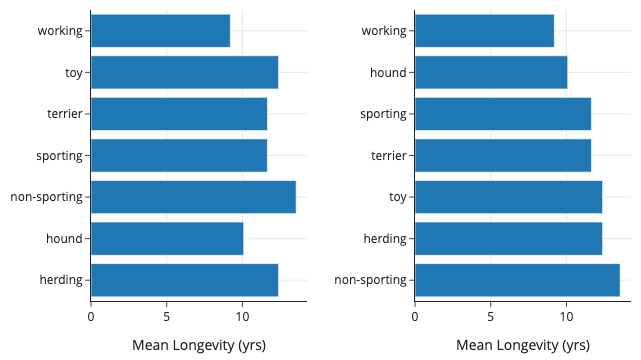

In [14]:
lons = dogs.groupby('group')[['longevity']].mean().reset_index()
f1 = px.bar(lons, x='longevity', y='group')
f2 = px.bar(lons.sort_values('longevity', ascending=False),
            x='longevity', y='group')

fig = left_right(f1, f2, width=600, height=200, horizontal_spacing=0.2)
fig.update_xaxes(title_text='Mean Longevity (yrs)')
fig

As another example, the two sets of box plots below each compare the distribution of sale price for houses in different cities in the San Francisco East Bay. We prefer the plot on the right since it has boxes ordered according to the median price for each city. Again, this ordering makes it easier to compare distributions across groups, in this case cities. We see that the lower quartile and median price in Albany and Walnut Creek are roughly the same but the prices in Walnut Creek have greater right skew.

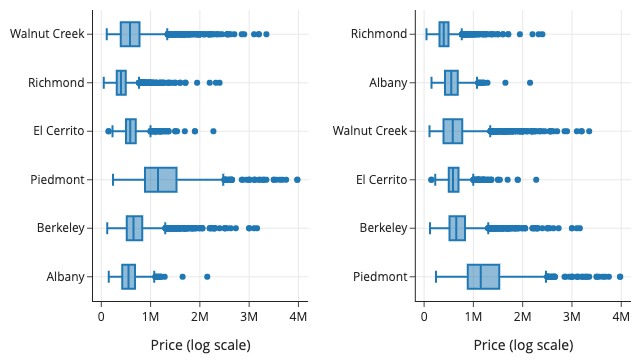

In [17]:
cities = ['Richmond', 'El Cerrito', 'Albany', 'Berkeley',
          'Walnut Creek', 'Lamorinda', 'Piedmont']

sfh_cities = sfh.query('city in @cities')


meds = (sfh_cities.groupby('city')
 ['price']
 .transform('median')
)
by_medians = (sfh_cities.assign(med=meds)
 .sort_values('med', ascending=False)
)

f1 = px.box(sfh_cities, x='price', y='city', log_x=True)
f2 = px.box(by_medians, x='price', y='city', log_x=True)
fig = left_right(f1, f2, horizontal_spacing=0.2)
fig.update_xaxes(title_text='Price (log scale)')
fig.update_layout(width=600, height=250)
fig

When possible, ordering bars in a bar plot by height and boxes in a box plot by median makes it easier for us to compare groups. Another technique used for presenting grouped data is stacking. We describe stacking in the next section and provide examples that are meant to convince you to stear away from this sort of plot. 

## Avoid Stacking

The figure below shows a stacked bar plot where there is one bar for each city and these bars are divided according to the proportion of houses sold that have 1, 2, 3, ..., 8+ bedrooms. This is called a *stacked bar plot*. Each bar has the same height of 1 because the segments represent the proportion of houses with 1, 2, 3,... bedrooms in a city and so add to 1 or 100%. 

In [23]:
br_crosstab = pd.crosstab(sfh_cities.city, sfh_cities.br, 
                          margins=False, normalize='index')

In [24]:
br_crosstab

br,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
city,,,,,,,,
Albany,1.21e-01,0.56,0.25,0.05,9.12e-03,1.01e-03,2.03e-03,4.05e-03
Berkeley,6.91e-02,0.38,0.31,0.16,4.44e-02,1.42e-02,6.48e-03,7.23e-03
El Cerrito,1.81e-02,0.34,0.47,0.14,2.20e-02,6.48e-03,0.00e+00,6.48e-04
Piedmont,8.63e-03,0.22,0.40,0.26,9.50e-02,1.29e-02,7.19e-03,1.44e-03
Richmond,3.60e-02,0.36,0.42,0.15,2.52e-02,7.21e-03,7.72e-04,7.72e-04
Walnut Creek,1.16e-01,0.35,0.30,0.18,4.37e-02,5.08e-03,4.12e-04,2.75e-04


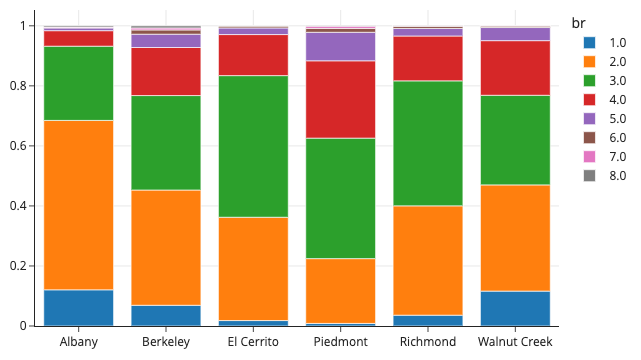

In [29]:
fig = px.bar(br_crosstab, width=450, height=300)
fig.update_layout(yaxis_title=None, xaxis_title=None)
fig.show()

It's easy to compare the proportion of one bedroom houses in each of the cities by simply scanning across the top of the first segment in each column. But the comparison of four bedroom houses is more difficult. The bottom of the segments are not aligned horizontally so our eyes must judge the lengths of segments that move up and down. This up and down movement is called "jiggling the baseline". 

Stacked line plots are even more difficult to read because we have to judge the gap between curves as they wiggle up and down. The plot below shows carbon dioxide (CO2) emissions from 1950 to 2012 for the ten highest emitters. 

In [30]:
co2 = pd.read_csv("data/co2_by_country.csv", skiprows = 2,
                  names = ["Country", "Year", "CO2"])
last_year = co2.Year.iloc[-1]
q = (f"Country not in ['World', 'European Union (15)', 'European Union (28)']"
     f"and Year == {last_year}")
top10_lasty = co2.query(q).sort_values('CO2', ascending=False).iloc[:10]
top10 = co2[co2.Country.isin(top10_lasty.Country) & (co2.Year >= 1950)]

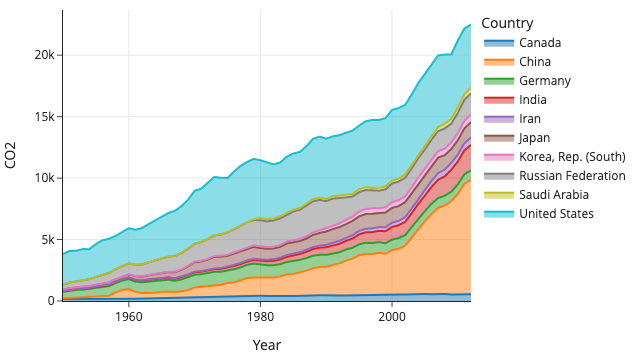

In [31]:
px.area(top10, x='Year', y='CO2',
              color='Country', line_group='Country',
              width=600, height=350)

Since the lines are stacked on top of each other, it's very hard to see how the emissions for a particular country has changed and it's hard to compare countries.
Instead, we can plot each country's line separately without stacking, as the plot
below illustrates. 

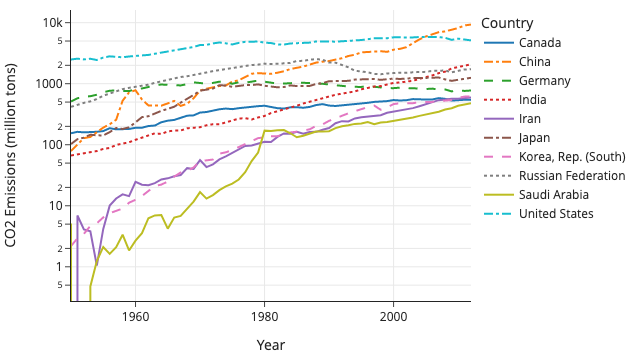

In [32]:
fig = px.line(top10, x='Year', y='CO2', color='Country',
              log_y=True,
              width=600, height=350)

# To make some lines dashed, dotted, dash-dot:
from itertools import cycle
styles = cycle([None, 'dashdot', 'dash', 'dot'])
for i in range(10):
    fig.update_traces(selector=i, 
                      line = dict(dash=next(styles)))
fig.update_yaxes(title_text='CO2 Emissions (million tons)')
fig

Now, it's much easier to see changes for individual countries and to compare countries because we need judge only 
y-axis positions rather than short vertical segments with different baselines. 
We see that some countries have had flat rates of growth in CO2 emissions (on a log scale), such as the United States and Japan, while others have increased much faster, like China and India, and Germany has slowed its CO2 emissions. These aspects were nearly impossible to see when a country's baseline jiggled across the plot.

Stacked bar and line plots hinder comparisons because they lack a constant baseline. In both of these plots, to make it easier to tell one country from the next, we have used different line types and colors. Choosing colors to facilitate comparisons relies on many considerations. This is the topic of the next section. 

## Selecting a Color Palette

Choosing colors also plays an important role in data visualization.
We want to avoid overly bright or dark colors so that we don't strain
readers' eyes.
We should also avoid color palettes that might be difficult for color-blind
people---7-10% of people (mostly males) are red-green color-blind.

For categorical data, we want to use a color palette that can clearly distinguish between
categories.
One example is shown in {numref}`Figure %s <qual_palette>`, which is 
incidentally the color palette we use for visualizations in this book.

```{figure} figures/qual_palette.svg
---
name: qual_palette
---

An example color palette for categorical data from the `seaborn` Python
package.
```

For numeric data, we want to use a sequential color palette that emphasizes
one side of the spectrum more than the other or a diverging color palette that equally emphasizes both ends of the spectrum and deemphasizes the middle.
An example of a sequential palette is shown in
{numref}`Figure %s <quant_palette>` and a diverging palette in
{numref}`Figure %s <div_palette>`.

```{figure} figures/quant_palette.png
---
name: quant_palette
---

An sequential color palette for numeric data.
```

```{figure} figures/div_palette.png
---
name: div_palette
---

An diverging color palette for numeric data.
```

We choose a sequential palette when we want to emphasize either low or high
values, like cancer rates.
We choose a diverging palette when we want to emphasize both extremes, like
for two-party election results. 

It's important to choose a perceptually uniform color palette.
The term "perceptually uniform" means that when a data value is doubled,
the color in the visualization looks twice as colorful to the human eye.
We also want to avoid colors that create an after-image when
we look from one part of the graph to another, colors of different intensity
that make one attribute appear more important than another, and colors that
color-blind people have trouble distinguishing between.
We strongly recommend using a palette or a palette generator made specifically for data visualizations.

Plots are meant to be examined for long periods of time so we should choose colors that don't impede the reader's ability to carefully read a plot.
Even more so, the use of color should not be gratuitous---colors should represent information.
Relatedly, people typically have trouble distinguishing between more than about seven colors so we limit the number of colors in a plot. Finally, colors can appear quite different when printed on paper in gray-scale than when viewed on a computer screen. When we choose colors, we keep in mind how our plots will be displayed.

Making accurate comparisons in a visualization is such an important goal that researchers have studied how well people perceive differences in colors and other plotting features such as angles and lengths. This is the topic of the next section.

## Guidelines for Comparisons in Plots

Researchers have studied how accurately people can read information displayed in different types of plots. They have found the following ordering, from most to least accurately judged.

1. Positions along a common scale, like in a rug plot, strip plot, or dot plot.
2. Positions on identical, non-aligned scales, like in a bar plot.
3. Length, like in a stacked bar plot.
4. Angle and slope, like in a pie chart.
5. Area, like in a stacked line plot or bubble chart.
6. Volume, density, and color saturation, like in a 3-dimensional bar plot, or hexbin plot.
7. Color hue, like in a chloropeth election map.

As an example, below on the left, a pie chart shows the proportion of houses sold in San Francisco that are 1, 2, 3, ..., 8+ bedrooms, and on the right is a bar chart with the same proportions.

In [60]:
props = sfh['br'].value_counts(dropna=True, normalize=True)*100
ind = np.arange(1,8)

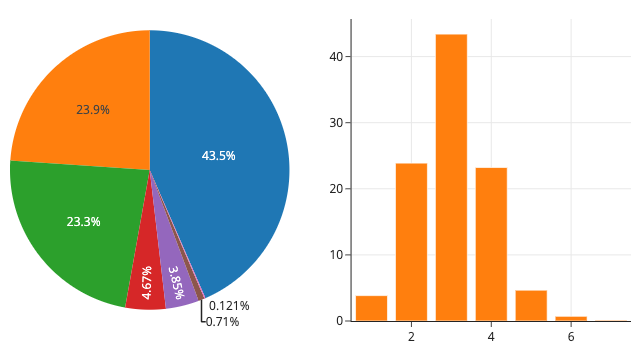

In [62]:
fig = make_subplots(rows=1, cols=2,
                   specs=[[{"type": "pie"}, {"type": "xy"}]])

fig.add_trace(go.Pie(values=props[ind], labels=ind), row=1, col=1)
fig.add_trace(go.Bar(x=ind, y=props[ind]), row=1, col=2)

fig.update_layout(showlegend=False, width=600, height=250)
fig.show()

It's hard to judge the angles in the pie, but the annotations with the actual percentages help us.
The bar chart is easier to read than the pie chart. Essentially, we rely on the percentages added to the slices in the pie to make comparisons and we lose the natural ordering of the feature when considering the shape of the distribution.

However there are exceptions to any rule. Multiple pie charts with only a few slices in each can provide effective comparisons.  For example, a set of pie charts of the proportion of two-bedroom houses sold in each of six cities
in the San Francisco East Bay, ordered according to the proportion, can create a useful visualization. Yet, sticking with the bar chart will generally always be at least as clear as any pie chart.  

Given these guidelines, we recommend sticking to position and length for making comparisons. People can more accurately read a plot that presents comparisons using position or length, rather than angle, area, volume, or color.
But, if we want to add additional information to a plot, we often use color, symbols, and line styles, in addition to position and length. We have shown several examples in this chapter. 

We next turn to the topic of data design and how to reflect the aspects of when, where, and how the data were collected in a visualization. This is a subtle but important topic. If we ignore the data scope, we can get very misleading plots.